In [1]:
import logging
import time
import jax
import optax
import data
import dataclasses

import matplotlib.pyplot as plt
import functools as ft
import haiku as hk
import typing as t
import jax.numpy as jnp
import numpy as np

### statics

In [2]:
# 36 is 3 hours, rounding up to the nearest power of 2 -> 64
BLOCK_SIZE = 32 # de facto it'll be x4 after byte encoding
BATCH_SIZE = 4
SPLIT = 0.85
LEARNING_RATE = 3e-4
SEED = 2137
NUM_TRAINING_STEPS = 50000
EVAL_INTERVAL = 1000
EMBEDDING_SIZE = 4

VOCAB_SIZE = 256
PAD_TOKEN = jnp.array(-1, dtype=jnp.int16)
GRAD_CLIP_VALUE = 1

NUM_LAYERS = 2  
NUM_HEADS = 16  # Number of attention heads.
MODEL_SIZE = 64
KEY_SIZE = 64
DROPOUT_RATE = 0.0
SOFTMAX_TEMP = 1.2

LOAD_WEIGHTS = True

### utils

In [3]:
class TrainingState(t.NamedTuple):
  """Container for the training state."""
  params: hk.Params
  opt_state: optax.OptState
  rng: jax.Array
  step: jax.Array

class Batch(t.NamedTuple):
    inputs: np.ndarray  # Integer tokens, shape [B, T]
    targets: np.ndarray  # Integer tokens, shape [B, T]

Metrics = t.MutableMapping[str, t.Any]

In [4]:
@jax.jit
def local_label_smoothing(arr: jnp.array, std: int = 2, mean: float = 0.7):
    # assert arr.shape[1] % EMBEDDING_SIZE == 0
    # [0, 0, 0, 1, 0, 0]
    #   into
    # [0, 0.05, 0.1, 0.7, 0.1, 0.05]
    il = jnp.argmax(arr) + 2*std
    arr = arr * mean
    _lin = jnp.arange(std) + 1
    coef  = (1 - mean) / 2 / _lin.sum()
    
    # TODO circular conv
    c = jnp.apply_along_axis(lambda x: jnp.convolve(jnp.array([.05, .1, .7, .1, .05]), x, mode="same"), -1, arr)
    return c

In [5]:
@jax.jit
def to_bytes(arr):
  """ Converts an array of uint32 into an array of bytes in little endian"""

  @ft.partial(jax.vmap, in_axes=(None, 0), out_axes=-1)
  def _to_bytes(arr, byte_index:int):
    mask = 0xFF << (8 * byte_index)
    b = (arr & mask) >> 8 * byte_index
    return  b.astype(jnp.uint16)

  return _to_bytes(arr, jnp.arange(4))

@ft.partial(jax.jit, static_argnames=("axis"))
def from_bytes(array, axis):
  """ Converts an array of bytes in little endian  into an array of uint32"""

  @ft.partial(jax.vmap, in_axes=(axis, -1))
  def _from_bytes(arr, byte_index):
    return arr << 8 * byte_index

  return jnp.sum(_from_bytes(array, jnp.arange(4)), axis=axis)

### load data

In [6]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.csv",
                            BLOCK_SIZE,
                            BATCH_SIZE,
                            EMBEDDING_SIZE,
                            SPLIT,
                            normalize=False,
                            log=False,
                            shift=False,
                            batch_first=True
                            )
train_di = sdl.get_data_iter("train")
test_di = sdl.get_data_iter("test")

In [7]:
expl_batch = next(train_di)
expl_batch["target"].shape

(4, 32)

In [8]:
expl_batch['input'][0, :4]

Array([9896693, 9095198, 8973590, 7857157], dtype=int32)

In [9]:
to_bytes(expl_batch['input'])[0, :3, :]

Array([[245,   2, 151,   0],
       [ 30, 200, 138,   0],
       [ 22, 237, 136,   0]], dtype=uint16)

In [10]:
@jax.jit
def preproc_data(batch: dict):
    _inputs = to_bytes(batch['input'])
    _targets = to_bytes(batch['target'])
    # TODO: make it a bit cleaner
    _inputs = _inputs.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    _targets = _targets.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    return Batch(inputs=_inputs, targets=_targets)

In [11]:
@jax.jit
def apply_byte_error_weights(arr: jnp.array):
    assert arr.shape[1] % EMBEDDING_SIZE == 0
    c = arr.shape[1] // EMBEDDING_SIZE
    weights = jnp.array([1., 2., 3., 4.] * c)
    return weights*arr

In [12]:
_inputs = preproc_data(expl_batch)
_inputs.inputs.shape

(4, 128)

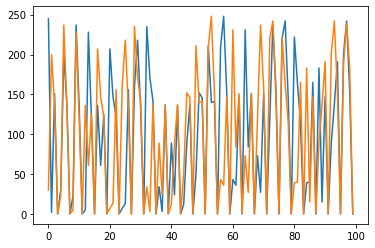

In [13]:
plt.figure()
plt.plot(_inputs.inputs[0, :100])
plt.plot(_inputs.targets[0, :100])
plt.show()

### model

from: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

In [14]:
"""Didactic example of an autoregressive Transformer-based language model.
Glossary of shapes:
- B: Batch size.
- T: Sequence length.
- D: Model embedding size.
- H: Number of attention heads.
- V: Vocabulary size.
"""

def layer_norm(x: jax.Array) -> jax.Array:
  """Applies a unique LayerNorm to x with default settings."""
  ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
  return ln(x)


@dataclasses.dataclass
class Transformer(hk.Module):
  """A transformer stack."""

  num_heads: int
  num_layers: int
  key_size: int
  dropout_rate: float
  widening_factor: int = 4
  name: t.Optional[str] = None

  def __call__(
      self,
      embeddings: jax.Array,  # [B, T, D]
      mask: jax.Array,  # [B, T]
      *,
      is_training: bool = True,
  ) -> jax.Array:  # [B, T, D]
    """Transforms input embedding sequences to output embedding sequences."""

    initializer = hk.initializers.VarianceScaling(2 / self.num_layers)
    dropout_rate = self.dropout_rate if is_training else 0.
    _, seq_len, model_size = embeddings.shape

    # Compute causal mask for autoregressive sequence modelling.
    mask = mask[:, None, None, :]  # [B, H=1, T'=1, T]
    causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
    mask = mask * causal_mask  # [B, H=1, T, T]

    h = embeddings
    for _ in range(self.num_layers):
      # First the attention block.
      attn_block = hk.MultiHeadAttention(
          num_heads=self.num_heads,
          key_size=self.key_size,
          model_size=model_size,
          w_init=initializer,
      )
      h_norm = layer_norm(h)
      h_attn = attn_block(h_norm, h_norm, h_norm, mask = mask)
      h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
      h = h + h_attn

      # Then the dense block.
      dense_block = hk.Sequential([
          hk.Linear(self.widening_factor * model_size, w_init=initializer),
          jax.nn.gelu,
          hk.Linear(model_size, w_init=initializer),
      ])
      h_norm = layer_norm(h)
      h_dense = dense_block(h_norm)
      h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
      h = h + h_dense

    return layer_norm(h)


@dataclasses.dataclass
class TransformerModel(hk.Module):
  """An autoregressive transformer-based model."""

  transformer: Transformer
  model_size: int
  vocab_size: int
  pad_token: int
  name: t.Optional[str] = None

  def __call__(
      self,
      tokens: jax.Array,
      *,
      is_training: bool = True,
  ) -> jax.Array:
    """Forward pass, producing a sequence of logits."""
    input_mask = jnp.greater(tokens, self.pad_token)
    unused_batch_size, seq_len = tokens.shape

    # Embed the input tokens and positions.
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(
        self.vocab_size, embed_dim=self.model_size, w_init=embed_init)
    token_embeddings = token_embedding_map(tokens)
    
    # TODO byte_position emb
    # [4, seq_len // 4, model_size] repeat
    # [1, 2, 3, 4], ..., -> [4, model_size]
    _byte_position_embeddings = hk.get_parameter(
        'byte_position_embeddings', [EMBEDDING_SIZE, self.model_size], init=embed_init)
    
    byte_position_embeddings = _byte_position_embeddings
    for _ in range((seq_len // EMBEDDING_SIZE) - 1) :
        byte_position_embeddings = jnp.concatenate(
            (byte_position_embeddings, _byte_position_embeddings), axis=0)
    byte_position_embeddings = jnp.concatenate(
        (byte_position_embeddings[2:3], byte_position_embeddings), axis=0)[None, :, :]
    
    positional_embeddings = hk.get_parameter(
        'positional_embeddings', [seq_len, self.model_size], init=embed_init)
    input_embeddings = token_embeddings + positional_embeddings + byte_position_embeddings # [B, T, D]

    # Run the transformer over the inputs.
    embeddings = self.transformer(
        input_embeddings,
        input_mask,
        is_training=is_training,
    )  # [B, T, D]

    # Decode the embeddings (here, we use untied weights).
    return hk.Linear(self.vocab_size)(embeddings)  # [B, T, V]

### training

In [51]:
def forward(tokens: t.Union[np.ndarray, jax.Array]) -> jax.Array:
    net = TransformerModel(
        model_size=MODEL_SIZE,
        vocab_size=VOCAB_SIZE,
        pad_token=PAD_TOKEN,
        transformer=Transformer(
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            key_size=KEY_SIZE,
            dropout_rate=DROPOUT_RATE,
        ),
    )
    return net(tokens)

# Create the optimiser.
optimiser = optax.chain(
  # optax.clip_by_global_norm(GRAD_CLIP_VALUE),
  optax.adam(LEARNING_RATE, b1=0.9, b2=0.99),
)

# Create the loss.
@hk.transform
def loss_fn(batch: Batch) -> jax.Array:
    """Computes the (scalar) loss on `data` w.r.t. params."""
    inp = batch.inputs[:, 3:]
    out = batch.targets[:,  :-3]
    
    logits = forward(inp)
    
    # this mask excludes -1's which we use as a padding in an input seq
    mask = jnp.greater(inp, jnp.array(-1, dtype=jnp.int16))
    targets = jax.nn.one_hot(out, VOCAB_SIZE)  # (B, T*D, 256)
    ### LOCAL LABEL SMOOTHING ###
    # targets = local_label_smoothing(targets)
    
    assert logits.shape == targets.shape
    
    log_likelihood = jnp.sum(targets * jax.nn.log_softmax(logits / SOFTMAX_TEMP), axis=-1) # (B, T)
    
    predictions = jnp.argmax(jax.nn.softmax(logits / SOFTMAX_TEMP), axis=-1)
    #  neighbouring classes are similar therefore we use calculate accuracy 
    #  for the closes 1 and 2 heighbours as well
    out = out.astype(jnp.int32) # convert to signed int in order to make correct comparisons
    acc = jnp.asarray(predictions == out)[:, :-1].reshape((BATCH_SIZE, BLOCK_SIZE-1, 4))
    acc3 = jnp.logical_and(predictions <= out + 1, predictions >= out - 1)
    acc3 = acc3[:, :-1].reshape((BATCH_SIZE, BLOCK_SIZE-1, 4))
    acc5 = jnp.logical_and(predictions <= out + 2, predictions >= out - 2)
    acc5 = acc5[:, :-1].reshape((BATCH_SIZE, BLOCK_SIZE-1, 4))

    metrics = {
        'accuracy': acc.mean(axis=(0, 1)),
        'accuracy_3': acc3.mean(axis=(0, 1)),
        'accuracy_5': acc5.mean(axis=(0, 1)),
    }
        
    ### BYTE-LEVEL ERROR SCALING ###
    # the last token is the first byte of the prediction
    # it's scaled by 1.0, so we can skip it and it would have the same effect
    log_likelihood = log_likelihood.at[:, :-1].set(apply_byte_error_weights(log_likelihood[:, :-1]))
    return -jnp.sum(log_likelihood * mask) / jnp.sum(mask), metrics  # NLL per token.

@jax.jit
def update(state: TrainingState, batch) -> t.Tuple[TrainingState, Metrics]:
    """Does an SGD step and returns metrics."""
    rng, new_rng = jax.random.split(state.rng)
    loss_and_grad_fn = jax.value_and_grad(loss_fn.apply, has_aux=True)
    (loss, metrics), gradients = loss_and_grad_fn(state.params, rng, batch)

    updates, new_opt_state = optimiser.update(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng=new_rng,
        step=state.step + 1,
    )

    metrics.update({
        'step': state.step,
        'loss': loss,
    })
    return new_state, metrics

In [52]:
rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
init_batch = preproc_data(expl_batch)
initial_params = loss_fn.init(init_rng, init_batch)

initial_opt_state = optimiser.init(initial_params)
initial_state =  TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng=init_rng,
    step=jnp.array(0),
)

valid_loss_all = []
train_loss_all = []

In [53]:
if LOAD_WEIGHTS:
    model_params = jnp.load('transformer_aka_karpathy.npy', allow_pickle=True)
else:
    avg_loss = []
    prev_time = time.time()
    state = initial_state
    for step in range(NUM_TRAINING_STEPS):
        batch = preproc_data(next(train_di))
        state, metrics = update(state, batch)
        # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
        # Using values from state/metrics too often will block the runahead and can
        # cause these overheads to become more prominent.
        avg_loss.append(float(metrics['loss']))
        # TODO:
        #  - add elapsed time in min
        if step % EVAL_INTERVAL == 0:
            steps_per_sec = EVAL_INTERVAL / (time.time() - prev_time)
            prev_time = time.time()
            rng, new_rng = jax.random.split(rng)
            valid_loss, _ = loss_fn.apply(state.params, new_rng, preproc_data(next(test_di))) 
            valid_loss_all.append(valid_loss)
            
            metrics.update({'steps_per_sec': steps_per_sec, 'valid_loss': valid_loss})
            # logging.info({k: float(v) for k, v in metrics.items()})
            print(f"Step: {step}, " \
                  f"Loss: {sum(avg_loss)/len(avg_loss):.2f}, " \
                  f"Vloss: {metrics['valid_loss']:.2f}, " \
                  f"Acc: {[f'{i:0.2f}' for i in metrics['accuracy']]}, " \
                  f"Acc3: {[f'{i:0.2f}' for i in metrics['accuracy_3']]}, " \
                  # f"Acc5: {metrics['accuracy_5']}, " \
                  f"")
            avg_loss = []
            

Step: 0, Loss: 15.14, Vloss: 11.81, Acc: ['0.00', '0.00', '0.00', '0.00'], Acc3: ['0.01', '0.01', '0.00', '0.00'], 
Step: 1000, Loss: 6.04, Vloss: 4.45, Acc: ['0.01', '0.02', '0.68', '1.00'], Acc3: ['0.01', '0.08', '0.85', '1.00'], 
Step: 2000, Loss: 5.37, Vloss: 7.14, Acc: ['0.01', '0.27', '0.63', '1.00'], Acc3: ['0.04', '0.29', '0.77', '1.00'], 
Step: 3000, Loss: 5.31, Vloss: 5.53, Acc: ['0.00', '0.00', '0.35', '0.86'], Acc3: ['0.00', '0.01', '0.52', '0.99'], 
Step: 4000, Loss: 5.21, Vloss: 5.28, Acc: ['0.01', '0.01', '0.25', '1.00'], Acc3: ['0.02', '0.02', '0.44', '1.00'], 
Step: 5000, Loss: 5.19, Vloss: 5.49, Acc: ['0.02', '0.06', '0.51', '1.00'], Acc3: ['0.02', '0.15', '0.57', '1.00'], 
Step: 6000, Loss: 5.20, Vloss: 6.48, Acc: ['0.01', '0.31', '0.69', '0.94'], Acc3: ['0.04', '0.41', '0.75', '0.99'], 
Step: 7000, Loss: 5.17, Vloss: 4.45, Acc: ['0.00', '0.12', '0.54', '0.98'], Acc3: ['0.01', '0.19', '0.58', '1.00'], 
Step: 8000, Loss: 5.14, Vloss: 5.78, Acc: ['0.01', '0.00', '0.57'

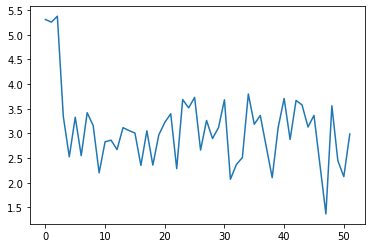

In [44]:
plt.figure()
plt.plot(valid_loss_all)
plt.plot(train_loss_all)
plt.show()

### validation

In [ ]:
if LOAD_WEIGHTS:
    model_weights = model_params.item()
else:
    model_weights = state.params

In [54]:
if not LOAD_WEIGHTS:
    with open('transformer_aka_karpathy_all_edges.npy', 'wb') as f:
        jnp.save(f, state.params)

In [ ]:
class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    output_seq: jnp.ndarray

In [ ]:
mask = jnp.array([1, 256, 256*256, 256*256*256])

In [ ]:
@hk.transform
def generate(context: jnp.array, seq_len: int) -> jnp.array:
    output_seq = jnp.zeros((BATCH_SIZE, seq_len))
    new_input = jnp.array(context[:, 3:], dtype = jnp.int32) # initial input

    def body_fn(idx: int, v: LoopValues) -> LoopValues:
        new_logits = forward(v.logits)  # (B, T*D, 256)
        print(new_logits.shape)
        new_logits = jax.random.categorical(hk.next_rng_key(), new_logits, axis=-1)  # (B, T*D)
        new_output_seq = v.output_seq.at[:, idx].set(new_logits[:, -1])
        return LoopValues(logits = new_logits, output_seq=new_output_seq)
        
    initial_values = LoopValues(logits=new_input, output_seq=output_seq)
    lv: LoopValues = hk.fori_loop(0, seq_len, body_fn, initial_values)        
    return lv.output_seq

@hk.transform
def generate_full_seq(context: jnp.array) -> jnp.array:
    inp = context[:, 3:]
    logits = forward(inp)  # (B, T*D, 256)
    
    logits = jnp.concatenate((logits, jnp.zeros((BATCH_SIZE, 3, 256))), axis=1)
    logits = jax.random.categorical(hk.next_rng_key(), logits, axis=-1)
    res_bytes = logits.reshape((BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE))
    
    res = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, res_bytes)
    return res

In [ ]:
test_batch = preproc_data(next(test_di))
rng = jax.random.PRNGKey(SEED + 10)
rng, new_rng = jax.random.split(rng)

_predictions = generate_full_seq.apply(model_weights, new_rng, test_batch.inputs)
_predictions.shape

In [ ]:
context = test_batch.targets.reshape((BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE))
context = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, context)

In [ ]:
context.shape

In [ ]:
print(f"MAE ... {jnp.mean(jnp.abs(_predictions- context))}")

In [ ]:
jnp.exp(-1.6)

In [ ]:
plt.figure()
plt.plot(context[0, :150], label="Truth")
plt.plot(_predictions[0, :150], label="Preds")
plt.legend()
plt.show()

In [ ]:
half_T = (BLOCK_SIZE * 4) // 2 
half_zeros_input = jnp.concatenate(
    (jnp.ones((BATCH_SIZE, half_T))*PAD_TOKEN, test_batch.inputs[:, :half_T]),
    axis=1)

predictions = generate.apply(model_weights, new_rng, half_zeros_input, half_T)
predictions.shape

In [ ]:
predictions = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, predictions.reshape((BATCH_SIZE, 128, 4)))

In [ ]:
targets = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, test_batch.targets.reshape((BATCH_SIZE, 256, 4)))

In [ ]:
(BLOCK_SIZE * 4) - 3

In [ ]:
test_data_full = sdl.edges_test_data  # (E, NUM_TEST_SAMPLES)
print(test_data_full.shape)

In [ ]:
def test_data_generator(data_full: jnp.array, rng) -> jnp.array:
    assert data_full.ndim == 1
    model_input_size = BLOCK_SIZE - 1
    seq_len = data_full.shape[0]
    
    data_full = data_full[:BLOCK_SIZE*16].reshape((16, BLOCK_SIZE))

    predictions_full = jnp.zeros((16, BLOCK_SIZE))
    for idx in range(16):
        print(f"{idx}/16")
        rng, new_rng = jax.random.split(rng)
        
        context = to_bytes(data_full[idx])     
        context = context.reshape((1, BLOCK_SIZE*EMBEDDING_SIZE))
        context = jnp.concatenate((context, jnp.zeros((1, BLOCK_SIZE*EMBEDDING_SIZE), dtype=jnp.uint8)), axis=0)
        b = generate_full_seq.apply(model_weights, new_rng, context)
        predictions_full = predictions_full.at[idx].set(b[0])

    return jnp.ravel(predictions_full)

In [ ]:
fin_result = test_data_generator(test_data_full[0], jax.random.PRNGKey(SEED + 11))

In [ ]:
plt.figure()
plt.plot(fin_result[10300:10400])
plt.plot(test_data_full[0, 10301:10401])
plt.show()

In [ ]:
jnp.mean(jnp.abs(fin_result[:-1] - test_data_full[0, 1:23040])).item()

In [ ]:
jnp.tril(jnp.ones((10, 10)))

### other tests

provide only 3/4 of the context and see what happens 

In [ ]:
offset = test_batch.inputs.shape[1] // 4
padded_input = jnp.pad(test_batch.inputs, ((0, 0), (offset, 0)))[:, :-offset]
padded_input.shape

In [ ]:
rng, new_rng = jax.random.split(rng)
predictions = generate_full_seq.apply(model_weights, new_rng, padded_input)
predictions.shape

In [ ]:
plt.figure()
plt.plot(predictions[0, 300:400])
# plt.plot(test_batch.targets[0, 300:400])
plt.show()

In [ ]:
@hk.transform
def sample(context: jnp.array) -> jnp.array:
    for _ in range(4):
        inpt_cond = context if context.shape[1] <= BLOCK_SIZE*4 - 3 else context[:, -(BLOCK_SIZE*4 - 3):]
        inpt_cond = jnp.array(inpt_cond, dtype = jnp.uint8)
        print(f"0 {inpt_cond.shape}, {inpt_cond.dtype}")
        logits = forward(inpt_cond)
        print(f"1 {logits.shape}")
        logits = jax.random.categorical(hk.next_rng_key(), logits, axis=-1)
        print(f"2 {logits.shape}")
        context = jnp.concatenate((context, logits[:, -1:]), axis=1)
    return context

test_batch = preproc_data(next(test_di))
logits = sample.apply(model_weights, new_rng, test_batch.inputs[:, 3:])

In [ ]:
logits.shape